# Setup

In [1]:
import os
import random
from dataclasses import dataclass
from tqdm import tqdm

import torch
from torch.distributions.normal import Normal
from torch.distributions.uniform import Uniform
import numpy as np
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from transformers import get_cosine_schedule_with_warmup
from diffusers import (
    StableDiffusionPipeline, 
    StableDiffusionImg2ImgPipeline,
    StableDiffusionInpaintPipeline, 
    StableDiffusionDepth2ImgPipeline
    )    
import wandb
import matplotlib.pyplot as plt

from data.datasets.web_dataset import get_dataset
from instructflow.utils import show_images, seed_everything   
from instructflow.generation import generate_euler, generate_euler_cfg

In [2]:
import yaml
from omegaconf import OmegaConf
import tempfile


with open("configs/sd2_baseline.yaml", "r") as fp:
    config = OmegaConf.load(fp.name)

config

{'trainer': {'num_epochs': 1, 'learning_rate': 0.0001, 'lr_warmup_steps': 500, 'device': 'cuda'}, 'model': {'model_id': 'stabilityai/stable-diffusion-2-1-base', 'num_inference_steps': 100}, 'system': {'pf32_precision': 'high', 'random_state': 42}, 'data': {'processor_name': '/home/jovyan/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-1-base/snapshots/5ede9e4bf3e3fd1cb0ef2f7a3fff13ee514fdf06/tokenizer', 'dataloader': {'batch_size': 64, 'num_workers': 40, 'shuffle': True}, 'storage_options': {'anon': False, 'key': 'officecds-user01', 'secret': 'jym0FuboUnR5VsPmCgYTGv1QQfglYZhPRWbEfS59', 'client_kwargs': {'endpoint_url': 'https://s3pd12.sbercloud.ru'}}, 'dataset': {'shuffle_num': 12000, 'image_size': 256, 'seed': 6955, 'data_file': '/home/jovyan/vladimir/imagen/kandinsky4/data/train.list'}, 'uncond_prob': 0.1}}

In [3]:
seed_everything(config.system.random_state)
torch.set_float32_matmul_precision(config.system.pf32_precision)

In [4]:
scale = T.Lambda(
    lambda x: x * 2 - 1
)

inverse_scale = T.Lambda(
    lambda x: (x + 1) / 2
)


transform = T.Compose([
    T.ToTensor(),
    scale
])

inverse_transform = T.Compose([
    inverse_scale,
    T.Lambda(lambda x: x.permute(1, 2, 0))
])

# Generating Images from Text

In [5]:
# Load the pipeline
pipe = StableDiffusionPipeline.from_pretrained(config.model.model_id).to(config.trainer.device)

/home/jovyan/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

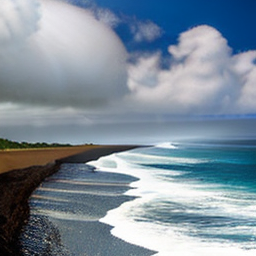

In [6]:
# Set up a generator for reproducibility
generator = torch.Generator(device=config.trainer.device).manual_seed(config.system.random_state)

# Run the pipeline, showing some of the available arguments
pipe_output = pipe(
    prompt="Surfer on maui", # What to generate
    negative_prompt="Oversaturated, blurry, low quality", # What NOT to generate
    height=256, 
    width=256,     # Specify the image size
    guidance_scale=4,          # How strongly to follow the prompt
    num_inference_steps=35,    # How many steps to take
    generator=generator        # Fixed random seed
)

# View the resulting image
pipe_output.images[0]

In [7]:
import math

approx_num_samples, dataset = get_dataset(config.data)
approx_num_batches = math.ceil(approx_num_samples / config.data.dataloader.batch_size)

dataloader = DataLoader(
        dataset,
        batch_size=config.data.dataloader.batch_size,
        num_workers=config.data.dataloader.num_workers,
        pin_memory=True,
    )

!!! DATASET SIZE !!! 278964


# Model

In [8]:
last_checkpoint = os.listdir("checkpoints/sd_2_1_fm_generation_v1")[-1]
last_checkpoint

'595000.pt'

In [9]:
unet = pipe.unet.eval()
vae = pipe.vae.eval()
text_encoder = pipe.text_encoder.eval()

unet.load_state_dict(torch.load(f"checkpoints/sd_2_1_fm_generation_v1/{last_checkpoint}"))

<All keys matched successfully>

In [10]:
batch = next(iter(dataloader))
batch

[tensor([[[[ 0.9529,  0.9529,  0.9529,  ...,  0.8902,  0.8902,  0.8824],
           [ 0.9529,  0.9529,  0.9529,  ...,  0.8902,  0.8902,  0.8824],
           [ 0.9529,  0.9529,  0.9529,  ...,  0.8902,  0.8902,  0.8824],
           ...,
           [ 0.7882,  0.7882,  0.7882,  ...,  0.3333,  0.3333,  0.3333],
           [ 0.7882,  0.7882,  0.7882,  ...,  0.3333,  0.3333,  0.3333],
           [ 0.7882,  0.7882,  0.7882,  ...,  0.3333,  0.3333,  0.3333]],
 
          [[ 0.2471,  0.2471,  0.2471,  ...,  0.1765,  0.1765,  0.1686],
           [ 0.2471,  0.2471,  0.2471,  ...,  0.1765,  0.1765,  0.1686],
           [ 0.2471,  0.2471,  0.2471,  ...,  0.1765,  0.1765,  0.1686],
           ...,
           [ 0.0118,  0.0118,  0.0118,  ..., -0.3882, -0.3804, -0.3804],
           [ 0.0118,  0.0118,  0.0118,  ..., -0.3882, -0.3804, -0.3804],
           [ 0.0118,  0.0118,  0.0118,  ..., -0.3882, -0.3804, -0.3804]],
 
          [[-0.6941, -0.6941, -0.6941,  ..., -0.7255, -0.7255, -0.7333],
           [-

# Generation

In [11]:
device = config.trainer.device
device

'cuda'

In [12]:
x_1, input_ids, attention_mask = batch
x_1, input_ids, attention_mask = x_1[:16].to(device), input_ids[:16].to(device), attention_mask[:16].to(device)

with torch.no_grad():
    x_1_latents = 0.18215 * vae.encode(x_1).latent_dist.mean

x_0_latent = torch.randn_like(x_1_latents, device=device)
x_0_latent.shape

torch.Size([16, 4, 32, 32])

In [13]:
null_prompts = [''] * 16
null_encoder_out = pipe.tokenizer(null_prompts, padding="max_length", max_length=32, return_tensors="pt")

with torch.no_grad():
    null_encoder_hidden_states = text_encoder(null_encoder_out["input_ids"].to(device), null_encoder_out["attention_mask"].to(device))['last_hidden_state']

null_encoder_hidden_states.shape

torch.Size([16, 32, 1024])

In [14]:
prompts = [
    "Yellow elephant, high resolution 4k",
    "Red jetski in the center of field with green graaa, 4k high resolution",
    "DJ in Sunglasses, hight resolution",
    "Rainbow Crystall, bright, 4k",
    "Hot dog and a dog in front of an Eifel Tower",
    "Pink Razer Kitty Earphones",
    "Pillow and blanket sleeping on the bed in a form of a human",
    "Neuralk Network",
    "Heisenberg synthesyzed crystal sugar",
    "Window with a Mars platen in it",
    "Beautil blue Sea",
    "Surfer on Maui, hight resolution, 4k",
    "Russian Person, hight resolution",
    "Russian Flag",
    "3 Kids playing baseball, cartoon style",
    "Researchers in the laboratory"    
]

encoder_out = pipe.tokenizer(prompts, padding="max_length", max_length=32, return_tensors="pt")

with torch.no_grad():
    encoder_hidden_states = text_encoder(encoder_out["input_ids"].to(device), encoder_out["attention_mask"].to(device))['last_hidden_state']

encoder_hidden_states.shape

torch.Size([16, 32, 1024])

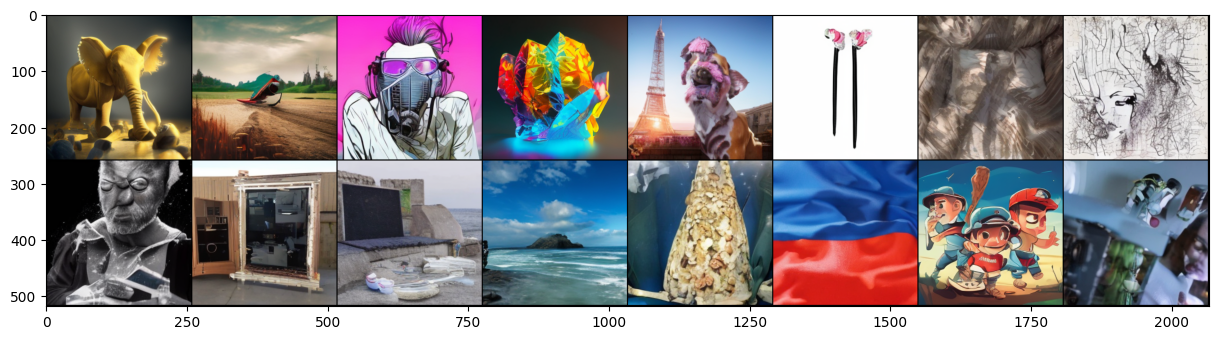

In [16]:
x_gen = generate_euler(unet=unet, vae=vae, x_0=x_0_latent[:16], encoder_hidden_states=encoder_hidden_states[:16], device=device)

plt.figure(figsize=(15, 7))
plt.imshow(show_images(x_gen))

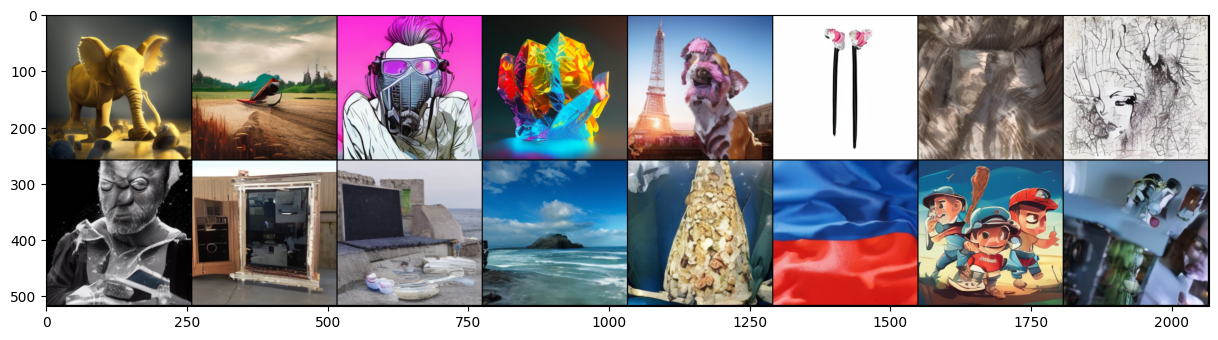

In [18]:
x_gen_cfg = generate_euler_cfg(
    unet=unet, 
    vae=vae, 
    x_0=x_0_latent[:16], 
    encoder_hidden_states=encoder_hidden_states[:16], 
    null_encoder_hidden_states=null_encoder_hidden_states, 
    guidance_scale=1,
    device=device
)

plt.figure(figsize=(15, 7))
plt.imshow(show_images(x_gen_cfg))

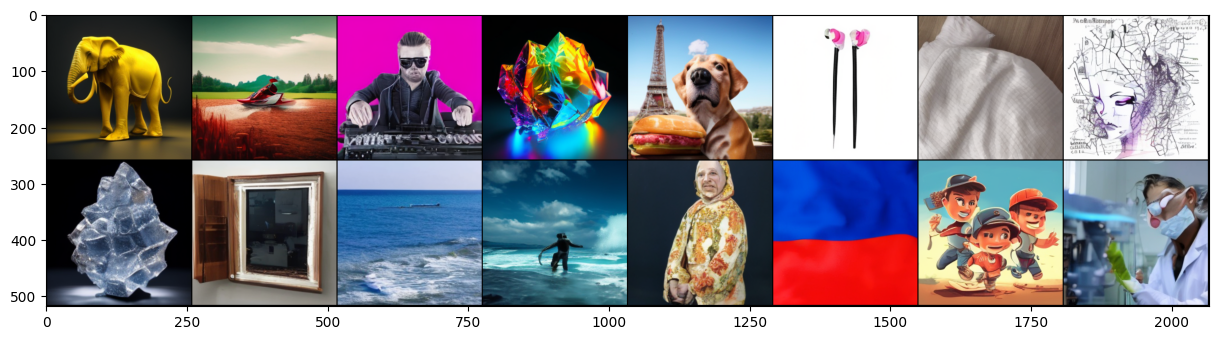

In [19]:
x_gen_cfg = generate_euler_cfg(
    unet=unet, 
    vae=vae, 
    x_0=x_0_latent[:16], 
    encoder_hidden_states=encoder_hidden_states[:16], 
    null_encoder_hidden_states=null_encoder_hidden_states, 
    guidance_scale=2,
    device=device
)

plt.figure(figsize=(15, 7))
plt.imshow(show_images(x_gen_cfg))

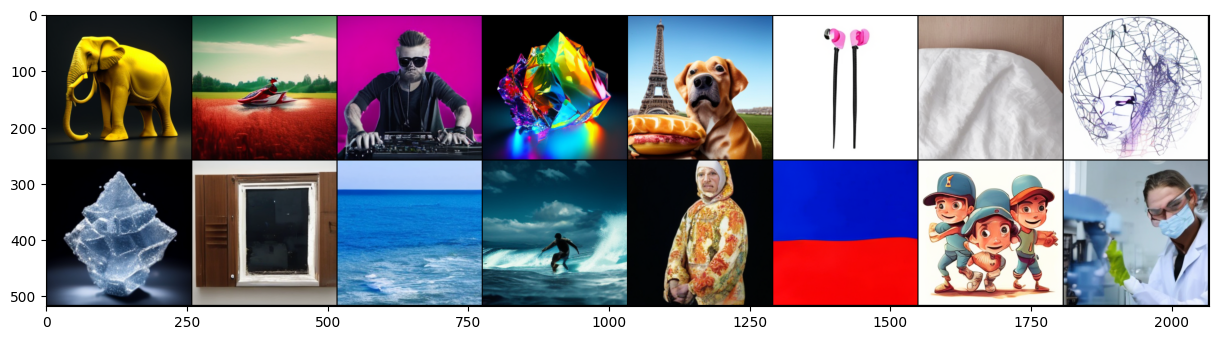

In [20]:
x_gen_cfg = generate_euler_cfg(
    unet=unet, 
    vae=vae, 
    x_0=x_0_latent[:16], 
    encoder_hidden_states=encoder_hidden_states[:16], 
    null_encoder_hidden_states=null_encoder_hidden_states, 
    guidance_scale=3,
    device=device
)

plt.figure(figsize=(15, 7))
plt.imshow(show_images(x_gen_cfg))

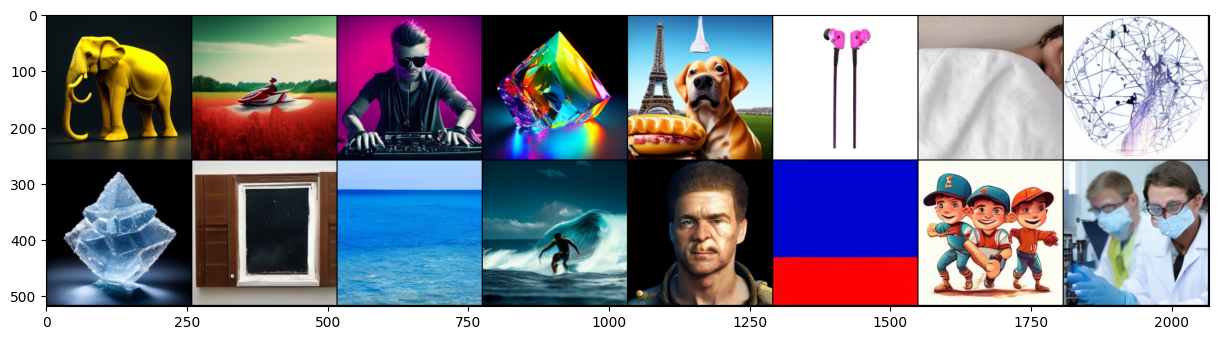

In [21]:
x_gen_cfg = generate_euler_cfg(
    unet=unet, 
    vae=vae, 
    x_0=x_0_latent[:16], 
    encoder_hidden_states=encoder_hidden_states[:16], 
    null_encoder_hidden_states=null_encoder_hidden_states, 
    guidance_scale=4,
    device=device
)

plt.figure(figsize=(15, 7))
plt.imshow(show_images(x_gen_cfg))

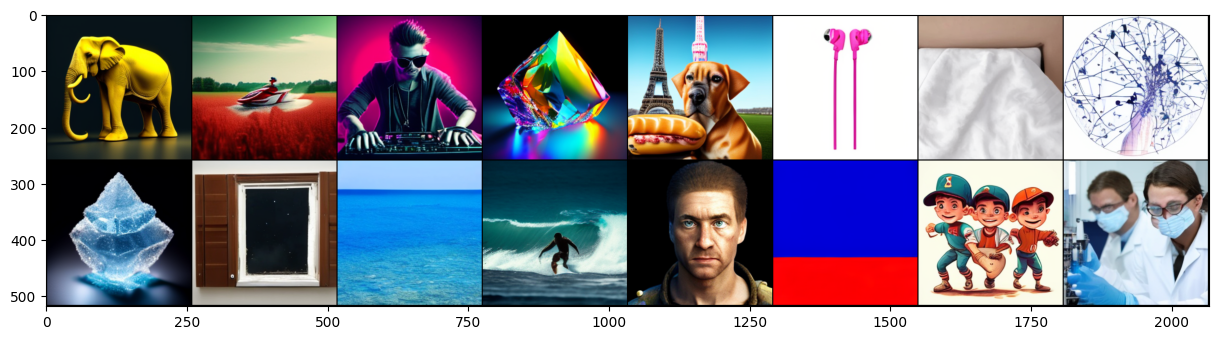

In [22]:
x_gen_cfg = generate_euler_cfg(
    unet=unet, 
    vae=vae, 
    x_0=x_0_latent[:16], 
    encoder_hidden_states=encoder_hidden_states[:16], 
    null_encoder_hidden_states=null_encoder_hidden_states, 
    guidance_scale=5,
    device=device
)

plt.figure(figsize=(15, 7))
plt.imshow(show_images(x_gen_cfg))

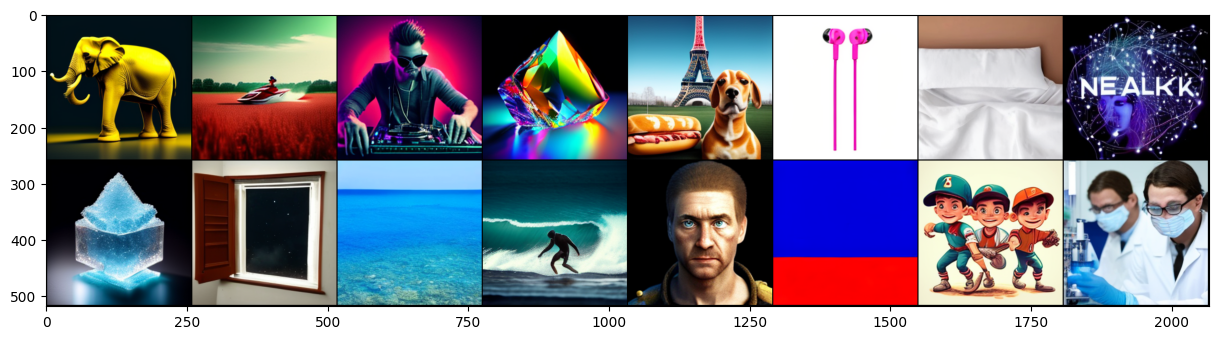

In [23]:
x_gen_cfg = generate_euler_cfg(
    unet=unet, 
    vae=vae, 
    x_0=x_0_latent[:16], 
    encoder_hidden_states=encoder_hidden_states[:16], 
    null_encoder_hidden_states=null_encoder_hidden_states, 
    guidance_scale=7,
    device=device
)

plt.figure(figsize=(15, 7))
plt.imshow(show_images(x_gen_cfg))

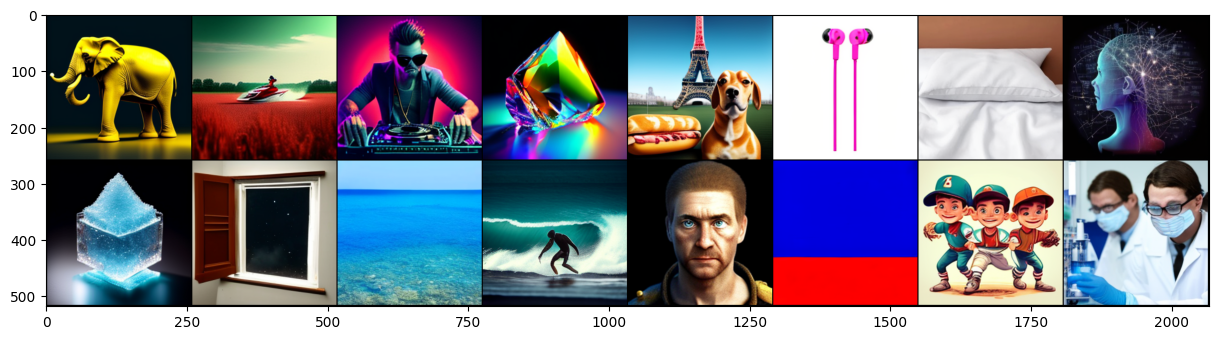

In [24]:
x_gen_cfg = generate_euler_cfg(
    unet=unet, 
    vae=vae, 
    x_0=x_0_latent[:16], 
    encoder_hidden_states=encoder_hidden_states[:16], 
    null_encoder_hidden_states=null_encoder_hidden_states, 
    guidance_scale=8,
    device=device
)

plt.figure(figsize=(15, 7))
plt.imshow(show_images(x_gen_cfg))

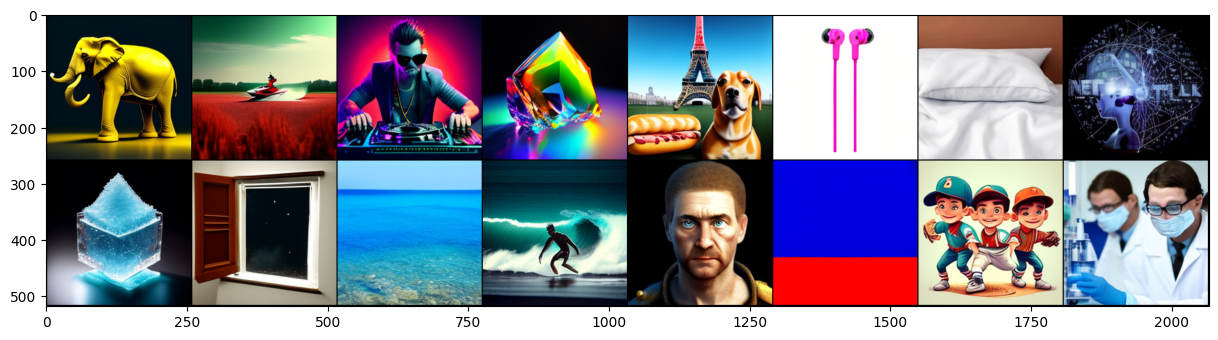

In [25]:
x_gen_cfg = generate_euler_cfg(
    unet=unet, 
    vae=vae, 
    x_0=x_0_latent[:16], 
    encoder_hidden_states=encoder_hidden_states[:16], 
    null_encoder_hidden_states=null_encoder_hidden_states, 
    guidance_scale=9,
    device=device
)

plt.figure(figsize=(15, 7))
plt.imshow(show_images(x_gen_cfg))

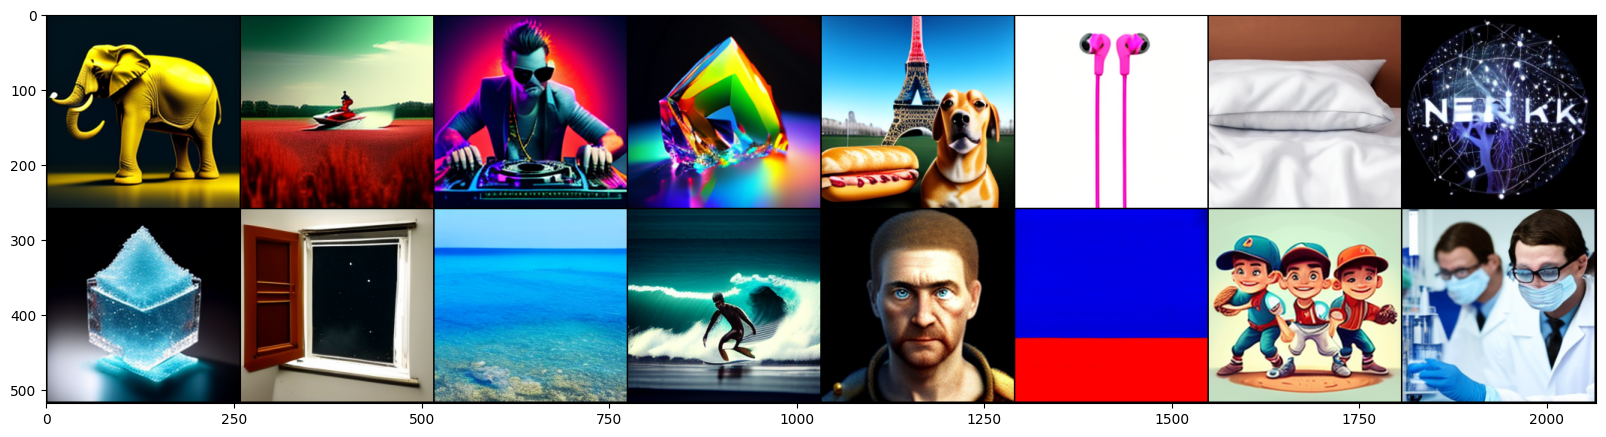

In [26]:
x_gen_cfg = generate_euler_cfg(
    unet=unet, 
    vae=vae, 
    x_0=x_0_latent[:16], 
    encoder_hidden_states=encoder_hidden_states[:16], 
    null_encoder_hidden_states=null_encoder_hidden_states, 
    guidance_scale=10,
    device=device
)

plt.figure(figsize=(20, 10))
plt.imshow(show_images(x_gen_cfg))

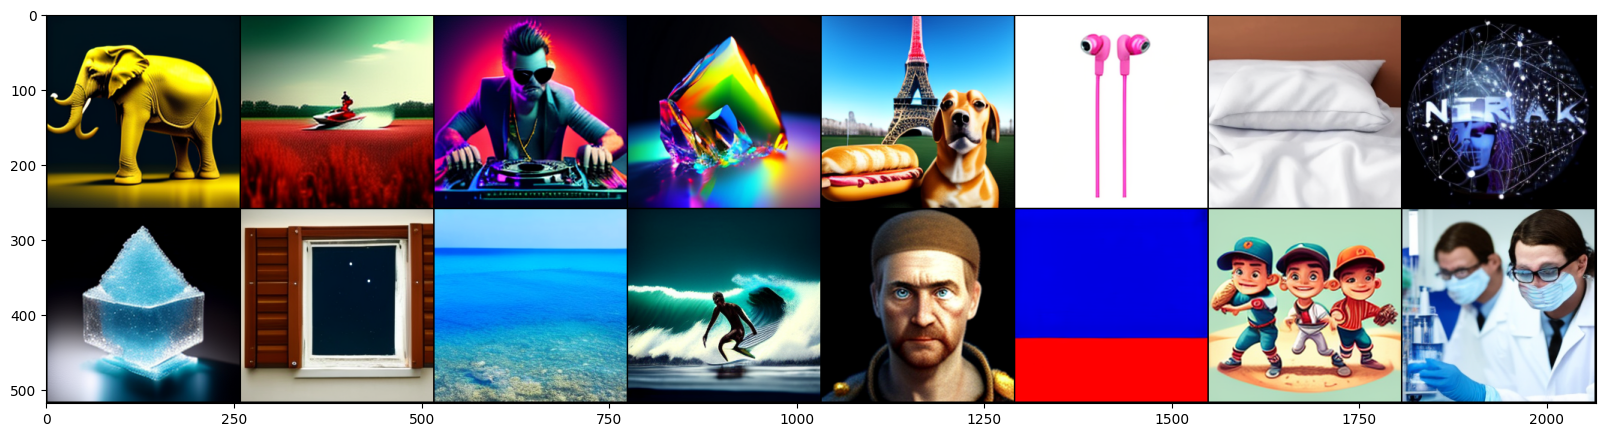

In [27]:
x_gen_cfg = generate_euler_cfg(
    unet=unet, 
    vae=vae, 
    x_0=x_0_latent[:16], 
    encoder_hidden_states=encoder_hidden_states[:16], 
    null_encoder_hidden_states=null_encoder_hidden_states, 
    guidance_scale=10,
    n_steps=50,
    device=device
)

plt.figure(figsize=(20, 10))
plt.imshow(show_images(x_gen_cfg))